## Preprocessing Timelapse Multi-plant trays by PlantCV

### PlantCV is an open-source image analysis software package targeted for plant phenotyping.


### Workflow
a) Optimize workflow on individual image with debug set to 'print' (or 'plot' if using a Jupyter notebook).

b) Run workflow on small test set (ideally that spans time and/or treatments).

c) Re-optimize workflows on 'problem images' after manual inspection of test set.

d) Deploy optimized workflow over test set using parallelization script.

 ### 1) Import libraries 


In [1]:
from plantcv import plantcv as pcv
import matplotlib 
import numpy as np
import cv2

### 2) Define class for set input variables

In [2]:
# It helps doing Parallelization
class options:
    def __init__(self):
        self.image = "C:/Users/usrlocal/Desktop/Ras1-1/sampleData/VIS_TV_AA0231.png" # define example image  
        #self.image = "C:/Users/usrlocal/Desktop/Ras1-1/sampleData/VIS_TV_AA0000.png" # Just tray
        #self.image = "C:/Users/usrlocal/Desktop/Ras1-1/sampleData/VIS_TV_AA0423.png" # define example image 
        #self.image = "C:/Users/usrlocal/Desktop/Ras1-1/sampleData/VIS_TV_AA0168.png" # Night image =black 
        #self.image = "C:/Users/usrlocal/Desktop/Ras1-1/sampleData/VIS_TV_AA0679.png"
        self.debug = "plot" #three options: none, Print, Plot
        self.writeimg= False 
        self.result = "multi_plant_results.json" # save the result in this file
        self.outdir = "./output_images/" # Store the output directory 
        self.Cropeddir = "./Croped_images/"
# Initialize options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug

# Increase text size in plots
pcv.params.text_size = 4
pcv.params.text_thickness = 4


### 3) Read image

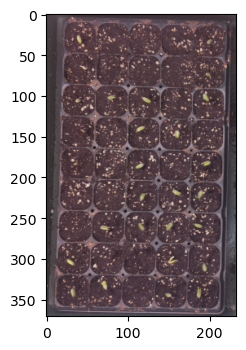

In [3]:
# Inputs:
#   filename - Image file to be read in 
#   mode - How to read in the image; either 'native' (default), 'rgb', 'gray', or 'csv'
img, path, filename = pcv.readimage(filename=args.image)


### 3) Image Normalization (if it is needed)

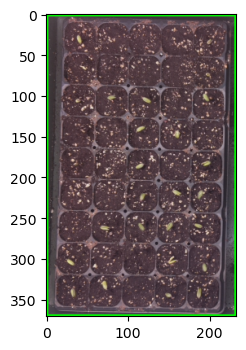

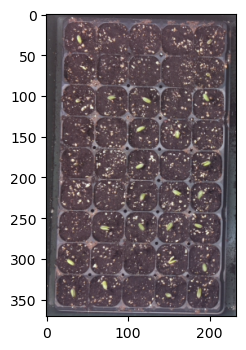

In [4]:
imgTest = pcv.white_balance(img, mode='hist', roi=None) #White balancing 


### 4) Image Rotation

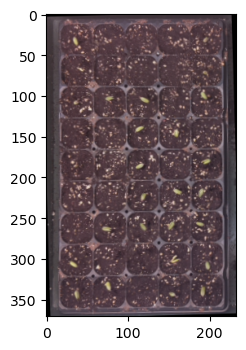

In [5]:
# Rotate the image slightly so the plants line up with 
# the grid that we'll add in a later step

# Inputs:
#   img = image object, RGB color space
#   rotation_deg = Rotation angle in degrees, can be negative, positive values 
#                  will move counter-clockwise 
#   crop = If True then image will be cropped to orginal image dimensions, if False
#          the image size will be adjusted to accommodate new image dimensions 
rotate_img = pcv.transform.rotate(img=img, rotation_deg=1.7, crop=True)

### 5) Crop Image

<IPython.core.display.Javascript object>


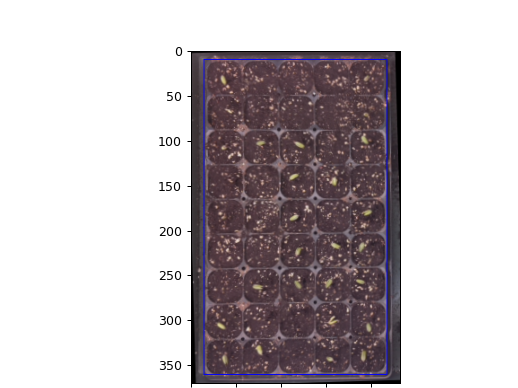

In [6]:
%matplotlib notebook
pcv.params.line_thickness = 1 # Default = 5

crop_img = pcv.crop(img=rotate_img, x=14, y=10, h=352, w=205)
img1=crop_img


### 6) Save croped-rotated  image

In [7]:
cv2.imwrite(args.Cropeddir+filename,img1)

True

### 7) Apply filtering

<IPython.core.display.Javascript object>


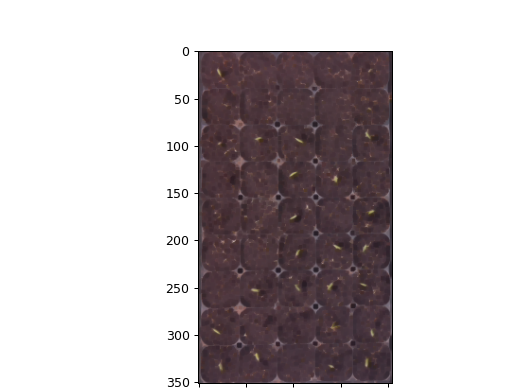

<IPython.core.display.Javascript object>


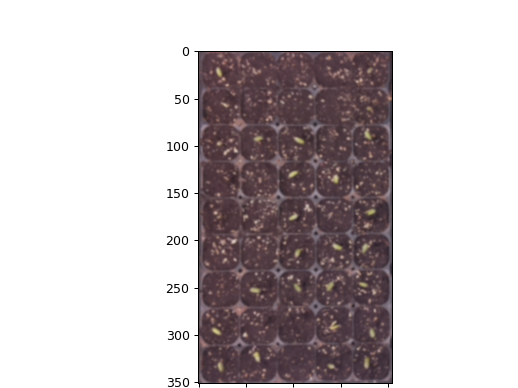

In [8]:
# Perform erosion filtering
# Results in removal of isolated pixels or boundary of object removal
er_img = pcv.erode(gray_img=img1, ksize=3, i=1)

#Applies a gaussian blur filter. 
gaussian_img = pcv.gaussian_blur(img=img1, ksize=(3, 3), sigma_x=0, sigma_y=None)


### 8) Visualize Potential Colorspaces

<IPython.core.display.Javascript object>


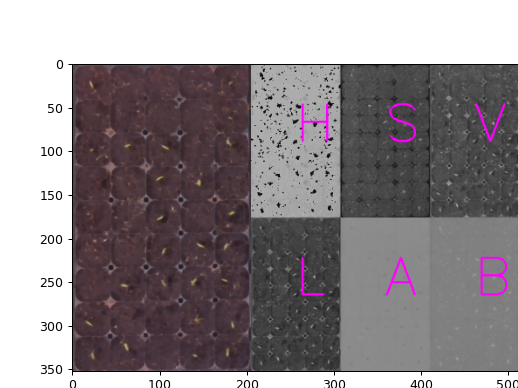

In [9]:
cs_plot = pcv.visualize.colorspaces(rgb_img=er_img, original_img=True)

### 9) Convert image from RGB color space to LAB or HSV color space 

<IPython.core.display.Javascript object>


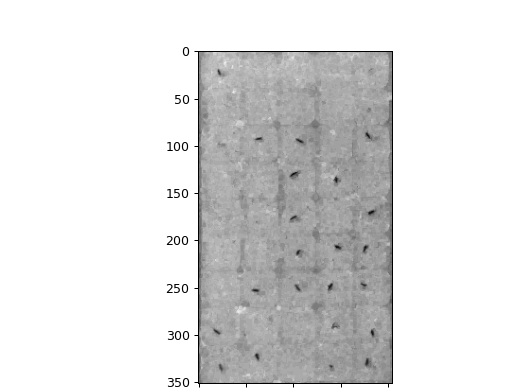

<IPython.core.display.Javascript object>


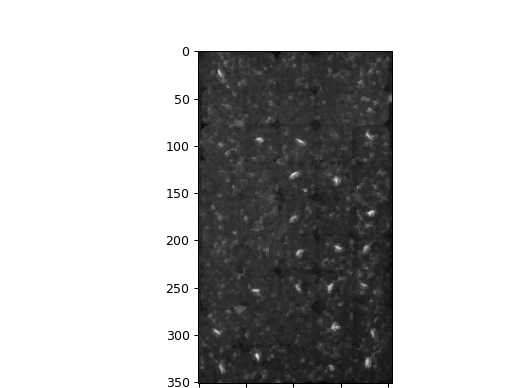

<IPython.core.display.Javascript object>


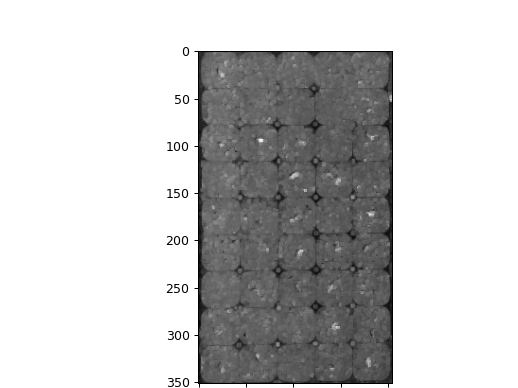

In [10]:
# Inputs:
#    rgb_img = image object, RGB color space
#    channel = color subchannel ('l' = lightness, 'a' = green-magenta , 'b' = blue-yellow)
a = pcv.rgb2gray_lab(rgb_img=er_img, channel='a') # Keep only the green-magenta channel (grayscale)
b = pcv.rgb2gray_lab(rgb_img=er_img, channel='b') #'b' = blue-yellow
s = pcv.rgb2gray_hsv(rgb_img=er_img, channel='s') # 's' = saturation

### 10) Object Segmentation Approaches - thresholding

<IPython.core.display.Javascript object>


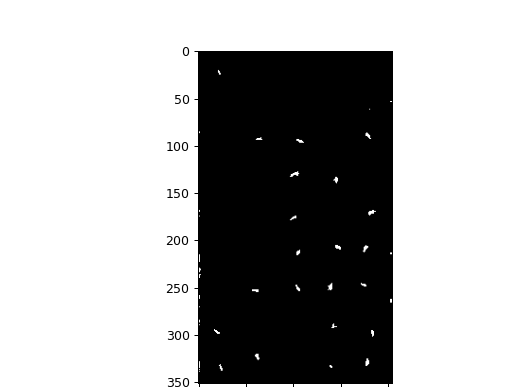

<IPython.core.display.Javascript object>


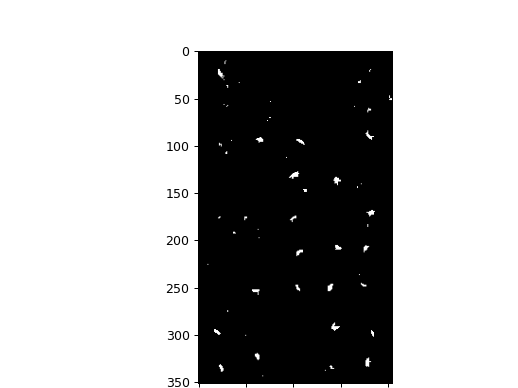

In [11]:
# Set a binary threshold on the saturation channel image

# Inputs:
#    gray_img    = img object, grayscale
#    threshold   = threshold value (0-255)
#    max_value   = value to apply above threshold (usually 255 = white)
#    object_type = light or dark
#       - If object is light then standard thresholding is done
#       - If object is dark then inverse thresholding is done
img_binary_a = pcv.threshold.binary(gray_img=a, threshold=131, max_value=255, object_type='dark') # for a channel

img_binary_b = pcv.threshold.binary(gray_img=b, threshold=138, max_value=255, object_type='light') # for b channel

### 11) Combine two images after applying different thresholds  (logical_and OR logical_or)


<IPython.core.display.Javascript object>


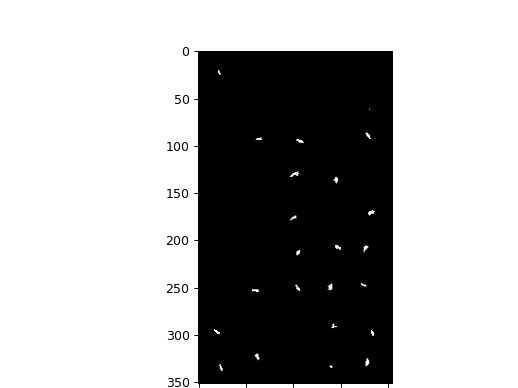

In [12]:
# For logical 'and' operation object pixel must be in both images 
# to be included in 'and' image.
a_b = pcv.logical_and(bin_img1=img_binary_a,bin_img2=img_binary_b)


### 12) Check if this is a night image or just a tray

In [13]:
#  To make sure that images are not taken at night we check that the image isn't mostly dark (0=black, 255=white).
# if it is a night image it throws a fatal error and stops the workflow.
if np.average(a_b) < 1:
    pcv.fatal_error("Night Image Or Just a tray!")
else:
    pass


### 13) Noise Reduction -'noise' (non-target-object spots) 

<IPython.core.display.Javascript object>


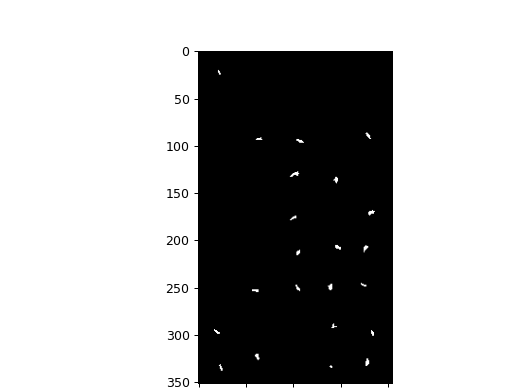

In [14]:
# Fill in small objects (speckles)

# Inputs:
#    bin_img  = binary image. img will be returned after filling
#    size     = minimum object area size in pixels (integer)
fill_image = pcv.fill(bin_img=a_b, size=2)                                        


### 14)  Dilate so that you don't lose leaves (just in case)

<IPython.core.display.Javascript object>


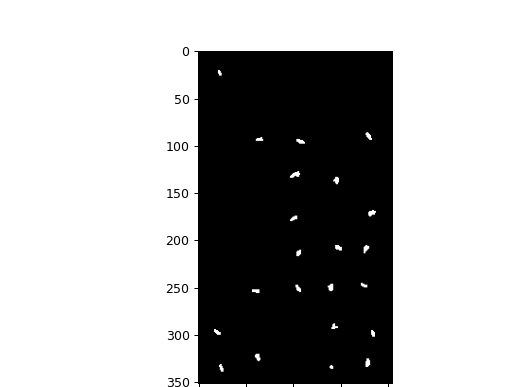

In [15]:
# Inputs:
#    gray_img = input image
#    ksize    = integer, kernel size
#    i        = iterations, i.e. number of consecutive filtering passes
dilated = pcv.dilate(gray_img=fill_image, ksize=2, i=1)


### 15) Find objects (apply mask for object detection)

<IPython.core.display.Javascript object>


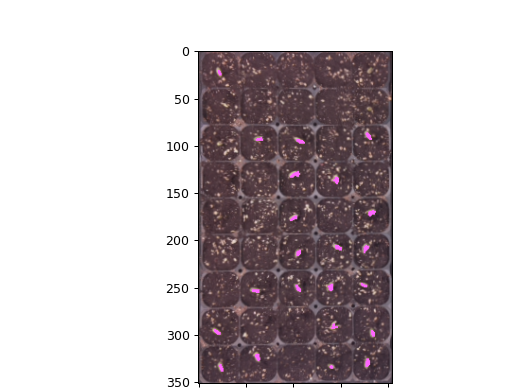

In [16]:
# Inputs:
#    img  = image that the objects will be overlayed
#    mask = what is used for object detection
id_objects, obj_hierarchy = pcv.find_objects(img=img1, mask=dilated)


### 16) Region of Interest - Keep objects that overlap with the ROI 

<IPython.core.display.Javascript object>


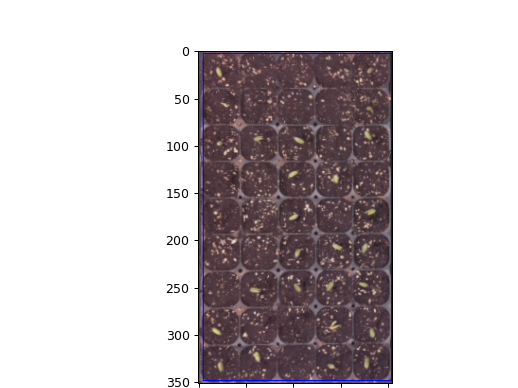

<IPython.core.display.Javascript object>


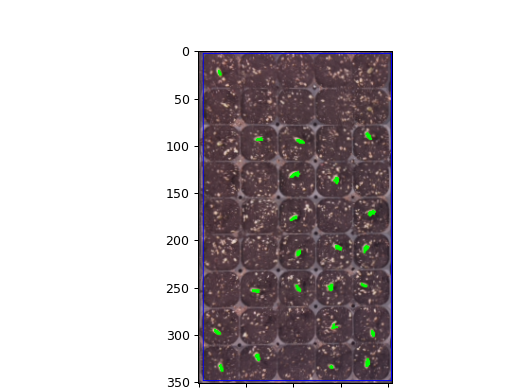

<IPython.core.display.Javascript object>


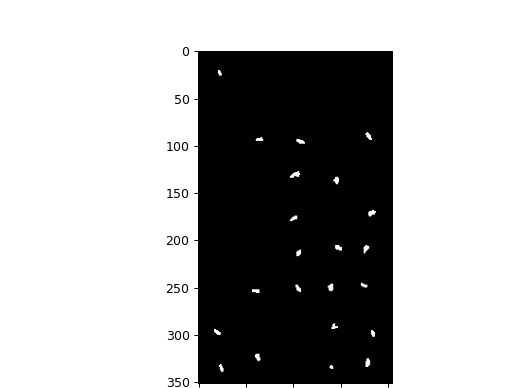

In [17]:
# in our case the ROI is the same as whole tray

pcv.params.line_thickness = 1# Default = 5

# Inputs:
#    img            = img to display kept objects
#    roi_contour    = contour of roi, output from any ROI function
#    roi_hierarchy  = contour of roi, output from any ROI function
#    object_contour = contours of objects, output from pcv.find_objects function
#    obj_hierarchy  = hierarchy of objects, output from pcv.find_objects function
#    roi_type       = 'partial' (default, for partially inside the ROI), 'cutto', or 
#                     'largest' (keep only largest contour)
roi_contour, roi_hierarchy = pcv.roi.rectangle(img=img1, x=5, y=3, h=347, w=200)

roi_objects, roi_obj_hierarchy, kept_mask, obj_area = pcv.roi_objects(img=img1, roi_contour=roi_contour, 
                                                                      roi_hierarchy=roi_hierarchy,
                                                                      object_contour=id_objects, 
                                                                      obj_hierarchy=obj_hierarchy, 
                                                                      roi_type='partial')



### 17- a) Clustering - Based on user input of rows and columns

<IPython.core.display.Javascript object>


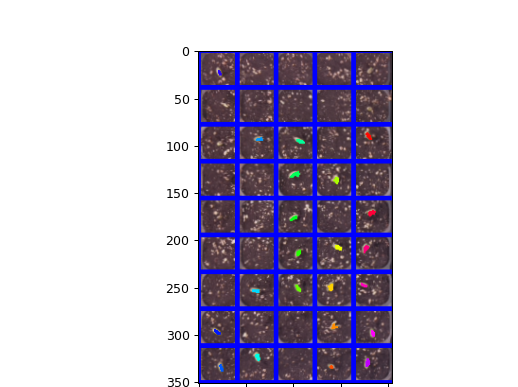

In [18]:
pcv.params.line_thickness = 3 # Default = 5

# This function take a image with multiple contours and clusters them based on user input of rows and columns
# Inputs:
#    img               = An RGB or grayscale image
#    roi_objects       = object contours in an image that are needed to be clustered.
#    roi_obj_hierarchy = object hierarchy
#    nrow              = number of rows to cluster (this should be the approximate  number of 
#                        desired rows in the entire image even if there isn't a literal row of plants)
#    ncol              = number of columns to cluster (this should be the approximate number of 
#                        desired columns in the entire image even if there isn't a literal row of plants)
#    show_grid         = if True then the grid is drawn on the image, default show_grid=False
clusters_i, contours, hierarchies = pcv.cluster_contours(img=img1, roi_objects=roi_objects, 
                                                         roi_obj_hierarchy=roi_obj_hierarchy, 
                                                         nrow=9, ncol=5, 
                                                         show_grid=True)


### 18) Plot to visualize each clusters

<IPython.core.display.Javascript object>


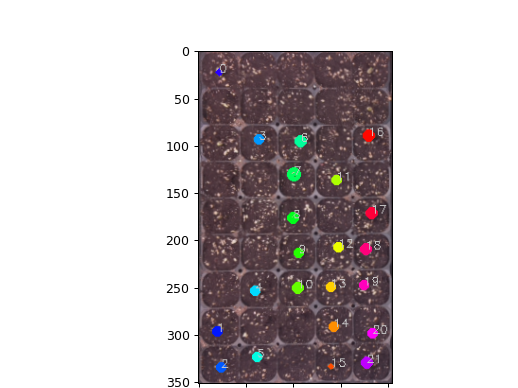

In [19]:
pcv.params.text_size = .4 
pcv.params.text_thickness = 1 

# Plot to visualize what pieces of plant got grouped together.

# Inputs:
#   img - RGB or grayscale image data for plotting
#   grouped_contour_indices - Indices for grouping contours
#   roi_objects - object contours in an image that are needed to be clustered.
#   roi_obj_hierarchy - object hierarchy
#   nrow - Optional, number of rows. If changed from default, grid gets plot. 
#   ncol - Optional, number of columns. If changed from default, grid gets plot. 
cluster_img = pcv.visualize.clustered_contours(img=img1, grouped_contour_indices=clusters_i, 
                                                roi_objects=contours,
                                                roi_obj_hierarchy=hierarchies)


#### 17- b) Segment features of images based on their distance to each other.

<IPython.core.display.Javascript object>


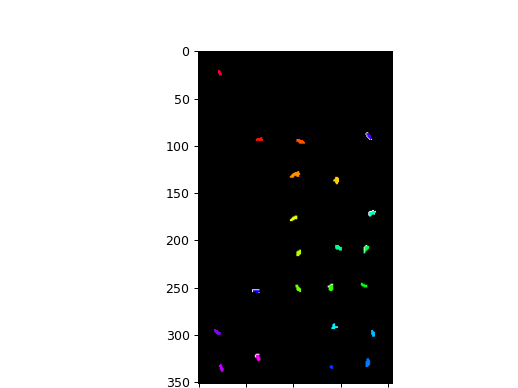

In [20]:
# Inputs:
# mask             = Mask/binary image to segment into clusters.
# algorithm        = Algorithm to use for segregating different clusters.
#                    Currently supporting OPTICS and DBSCAN. (Default="DBSCAN") Density-based spatial clustering of applications with noise (DBSCAN)
# min_cluster_size = The minimum size a section of a mask must be (in pixels)
#                    before it can be considered its own cluster. (Default=5)
# max_distance     = The total distance between two pixels for them to be considered a part
#                    of the same cluster.  For the DBSCAN algorithm, value must be between
#                    0 and 1.  For OPTICS, the value is in pixels and depends on the size
#                    of your picture.  (Default=0)
clust_img, clust_masks = pcv.spatial_clustering(mask=kept_mask, algorithm="OPTICS", min_cluster_size=5, max_distance=None)


### 19) Cluster Contours and Split Images

In [21]:
# This function takes clustered contours and splits them into multiple images,
# also does a check to make sure that the number of inputted filenames matches the number
# of clustered contours. If no filenames are given then the objects are just numbered

# Inputs:
#    img                     = ideally a masked RGB image.
#    grouped_contour_indexes = output of cluster_contours, indexes of clusters of contours
#    contours                = contours to cluster, output of cluster_contours
#    hierarchy               = object hierarchy
#    outdir                  = directory for output images
#    file                    = the name of the input image to use as a base name , output of filename from read_image function
#    filenames               = input txt file with list of filenames in order from top to bottom left to right (likely list of genotypes)

# Set global debug behavior to None (default), "print" (to file), or "plot" (Jupyter Notebooks or X11)
pcv.params.debug = "print"

out = args.outdir
  
output_path = pcv.cluster_contour_splitimg(img=img1, grouped_contour_indexes=clusters_i, contours=contours, 
                                           hierarchy=hierarchies, outdir=out, file=filename, filenames=None)


This function has been updated to include object hierarchy so object holes can be included


To view and/or download the text file output (saved in JSON format)...
1) To see the text file with data that got saved out, click “File” tab in top left corner.
2) Click “Open…”
3) Open the multi-plant text files 

Check out documentation on how to [convert JSON](https://plantcv.readthedocs.io/en/latest/tools/#convert-output-json-data-files-to-csv-tables) format output into table formatted output. Depending on the analysis steps a PlantCV user may have two CSV files (single value traits and multivalue traits). 


